In [23]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import sys
import os
from pathlib import Path
from importlib import reload

sys.path.append('../')
import waveform_processing as proc
reload(proc)

plt.style.use('dark_background')
#matplotlib.rcParams.keys()
plt.rcParams['figure.figsize'] = (10, 6)
plt.rc('font', size=12)
length = 8
width = 1.5
plt.rcParams['xtick.major.size'] = length
plt.rcParams['ytick.major.size'] = length
plt.rcParams['xtick.major.width'] = width
plt.rcParams['ytick.major.width'] = width

# Independent and principal component analysis of the pulse data

Test alternative methods to analyze the two pulse intensity
- PCA
- ICA

and compare them to the current SVD method.


From sklearn:

Independent component analysis separates a multivariate signal into additive subcomponents that are maximally independent. It is implemented in scikit-learn using the __Fast ICA__ algorithm. Typically, ICA is not used for reducing dimensionality but for separating superimposed signals.

In [24]:
res_path = Path('/reg/d/psdm/sxr/sxrx30416/results/espov/')

from scipy.signal import savgol_filter

def removeBackground(signal, ave_window=[0,500]):
    """
    Set the baseline of the waveform to 0
    """
    if signal.ndim ==1:
        return signal - np.median(signal[ave_window[0]:ave_window[1]])
    elif signal.ndim==2:
        med = np.median(signal[:,ave_window[0]:ave_window[1]], axis=1)  
        return signal - med.reshape(med.shape[0],1)

def filt(waveform, method='savgol', **kwargs):
    if method is 'savgol':
        if 'window_length' in kwargs:
            window_length= kwargs.pop('window_length')
        else:
            window_length = 15
        if 'polyorder' in kwargs:
            polyorder = kwargs.pop('polyorder')
        else:
            polyorder = 3
        return savgol_filter(waveform, window_length, polyorder)
    elif method is 'fft':
        if 'threshold' in kwargs:
            threshold = kwargs.pop('threshold')
        else:
            threshold = 1000
        ft = np.fft.rfft(waveform)
        ft[threshold:] = 0
        return np.fft.irfft(ft)

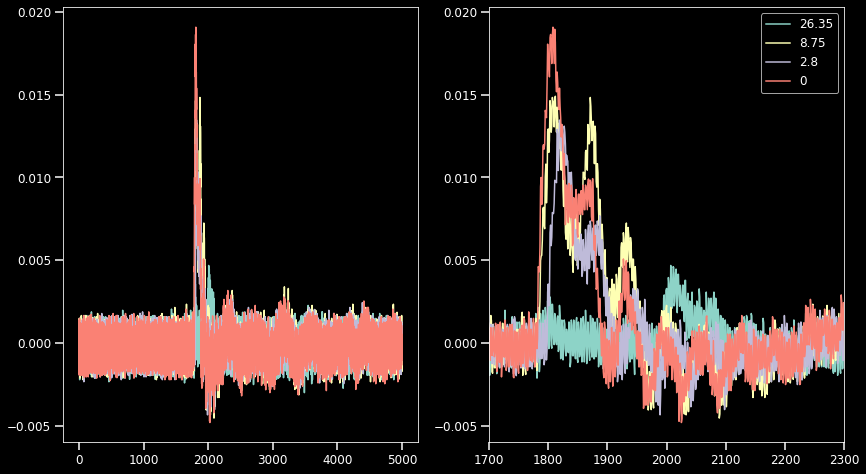

In [33]:
runs = [12,10,11,8] # 26.35 ns, 8.75 ns, 2.8 ns, 0 ns
dl = [26.35, 8.75, 2.8, 0] # ns
dat = []

plt.figure(figsize=(14,8))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
for ii, run in enumerate(runs):
#     fname = res_path / 'MCP_data' / 'MCP_r{}_small.h5'.format(run)
    fname = res_path / 'MCP_data' / 'run{}_MCP.h5'.format(run)
    with h5.File(fname, 'r') as f:
#         dat.append(np.asarray(f['MCP']))
        dat.append(np.asarray(f['waveform'][:1000]))
    
    sig = dat[ii][0]
    ax1.plot(sig)
    sig = dat[ii][0]
    ax2.plot(sig, label=str(dl[ii]))

ax2.set_xlim(1700,2300)
plt.legend()
plt.show()

## Remove background and smooth data

In [34]:
dat = [removeBackground(d) for d in dat]
dat = [filt(d, window_length=15) for d in dat]

inds = [1500,2600]
dat = [d[:,inds[0]:inds[1]] for d in dat]

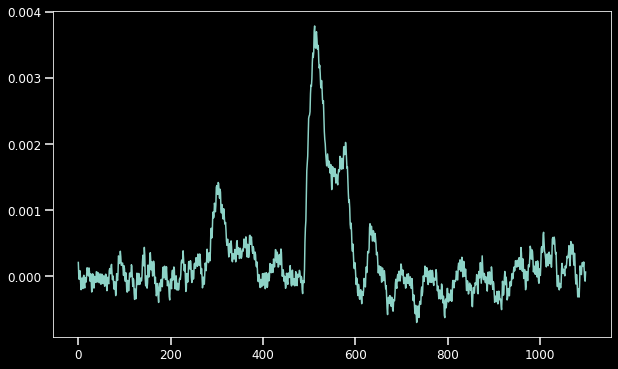

In [35]:
rii = 0
data = dat[rii]
data.shape
plt.plot(data[0])
plt.show()

# PCA

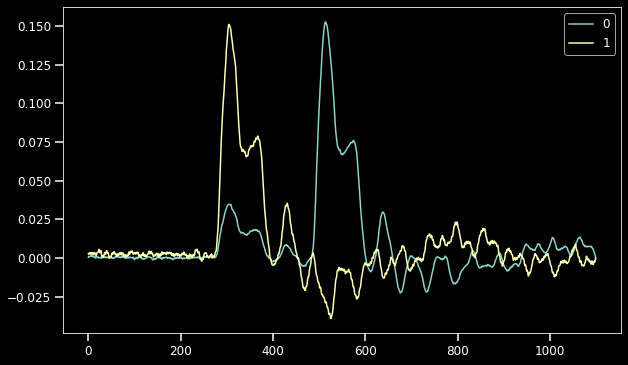

In [36]:
from sklearn.decomposition import PCA
n_components = 2
pca = PCA(n_components=n_components)
pca.fit(data[:200,:])

for ii in range(n_components):
    plt.plot(pca.components_[ii,:], label=str(ii))
# plt.xlim(4500,5500)
plt.legend()
plt.show()

[[-0.00797338  0.01313063]]


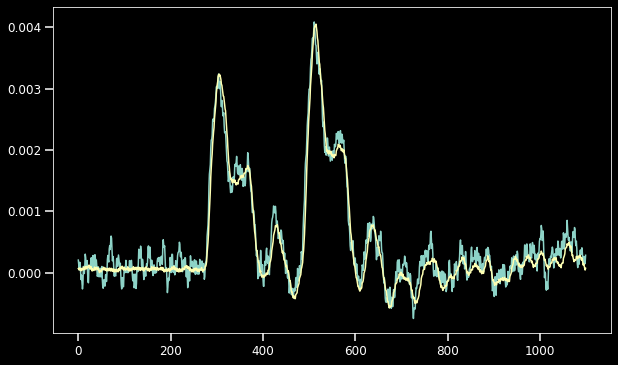

In [37]:
wave = data[215]
coeffs = pca.transform(wave.reshape(1,-1))
print(coeffs)
fit = pca.inverse_transform(coeffs)
plt.plot(wave)
plt.plot(fit.T)
plt.show()
# plt.xlim(4500,5500)

In [55]:
coeffs = pca.fit_transform(data[:10])
coeffs

array([[-0.01387484, -0.00267213],
       [ 0.03544233,  0.00385202],
       [ 0.00400068, -0.00463228],
       [ 0.00417834, -0.00382239],
       [-0.01188015, -0.0079954 ],
       [-0.02930747, -0.00352181],
       [-0.03045527, -0.00613997],
       [ 0.04100002, -0.00670848],
       [-0.00803294,  0.03135034],
       [ 0.00892931,  0.00029009]])

In [56]:
data[:10].shape

(10, 1100)

In [57]:
data[:10].dot(pca.components_.T)

array([[ 0.02339474,  0.00383028],
       [ 0.0727119 ,  0.01035442],
       [ 0.04127026,  0.00187012],
       [ 0.04144792,  0.00268001],
       [ 0.02538942, -0.001493  ],
       [ 0.00796211,  0.00298059],
       [ 0.0068143 ,  0.00036243],
       [ 0.0782696 , -0.00020608],
       [ 0.02923664,  0.03785274],
       [ 0.04619889,  0.00679249]])

# ICA

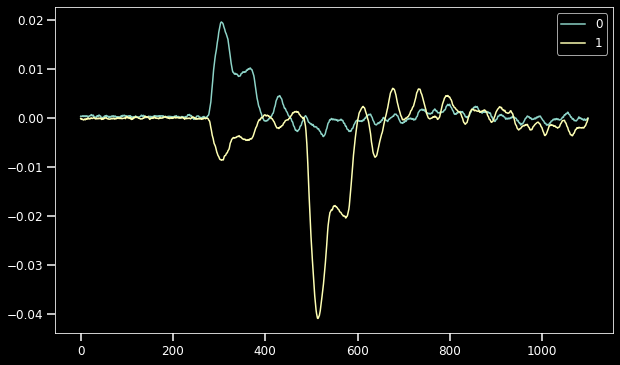

In [38]:
from sklearn.decomposition import FastICA
n_components = 2
ica = FastICA(n_components=n_components)
ica.fit(data[:200,:])

for ii in range(n_components):
    plt.plot(ica.mixing_[:,ii], label=str(ii))
# plt.xlim(4500,5500)
plt.legend()
plt.show()

[[0.10180136 0.03355533]]


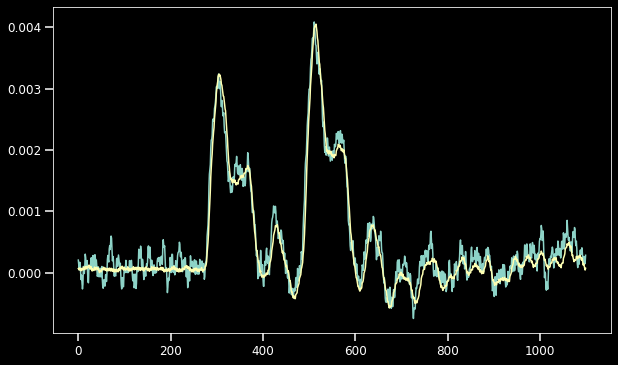

In [39]:
wave = data[215]
coeffs = ica.transform(wave.reshape(1,-1))
print(coeffs)
fit = ica.inverse_transform(coeffs)
plt.plot(wave)
plt.plot(fit.T)
plt.show()
# plt.xlim(4500,5500)

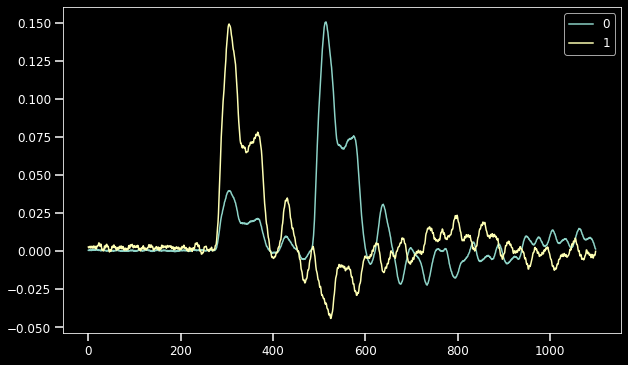

In [40]:
from sklearn.decomposition import TruncatedSVD
n_components = 2
svd = TruncatedSVD(n_components=n_components)
svd.fit(data[:200,:])

for ii in range(n_components):
    plt.plot(svd.components_[ii,:], label=str(ii))
# plt.xlim(4500,5500)
plt.legend()
plt.show()